### Identifying Outliers using Variational Autoencoders
Team Members:
1. Paavaneeswar Reddy CS22BTECH11014
2. Mohammed Gufran Ali CS22BTECH11040
3. M Bhavesh Choudary CS22BTECH11041

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

#### Load and preprocess the data

In [2]:
data = pd.read_csv('data.csv')

# Display basic information about the dataset
print("\nDataset Information:")
print(f"Shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")


Dataset Information:
Shape: (1199, 10)
Columns: ['cov1', 'cov2', 'cov3', 'cov4', 'cov5', 'cov6', 'cov7', 'sal_pur_rat', 'igst_itc_tot_itc_rat', 'lib_igst_itc_rat']



##### Visualize the distribution of features

<Figure size 1500x1000 with 0 Axes>

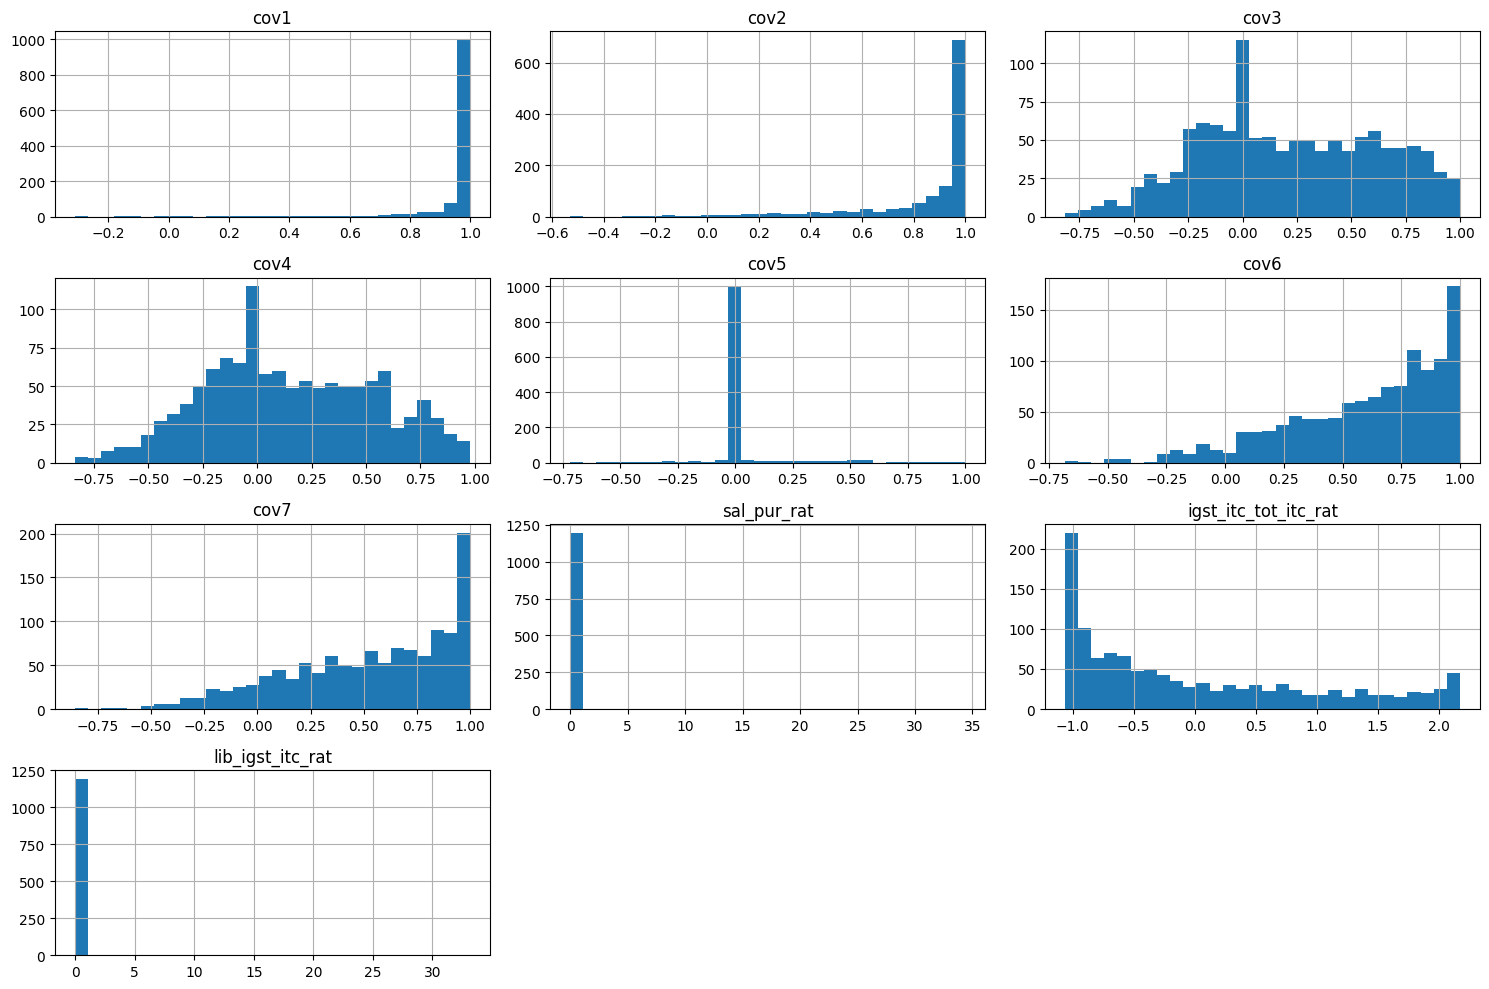

In [3]:
plt.figure(figsize=(15, 10))
data.hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

##### Correlation matrix

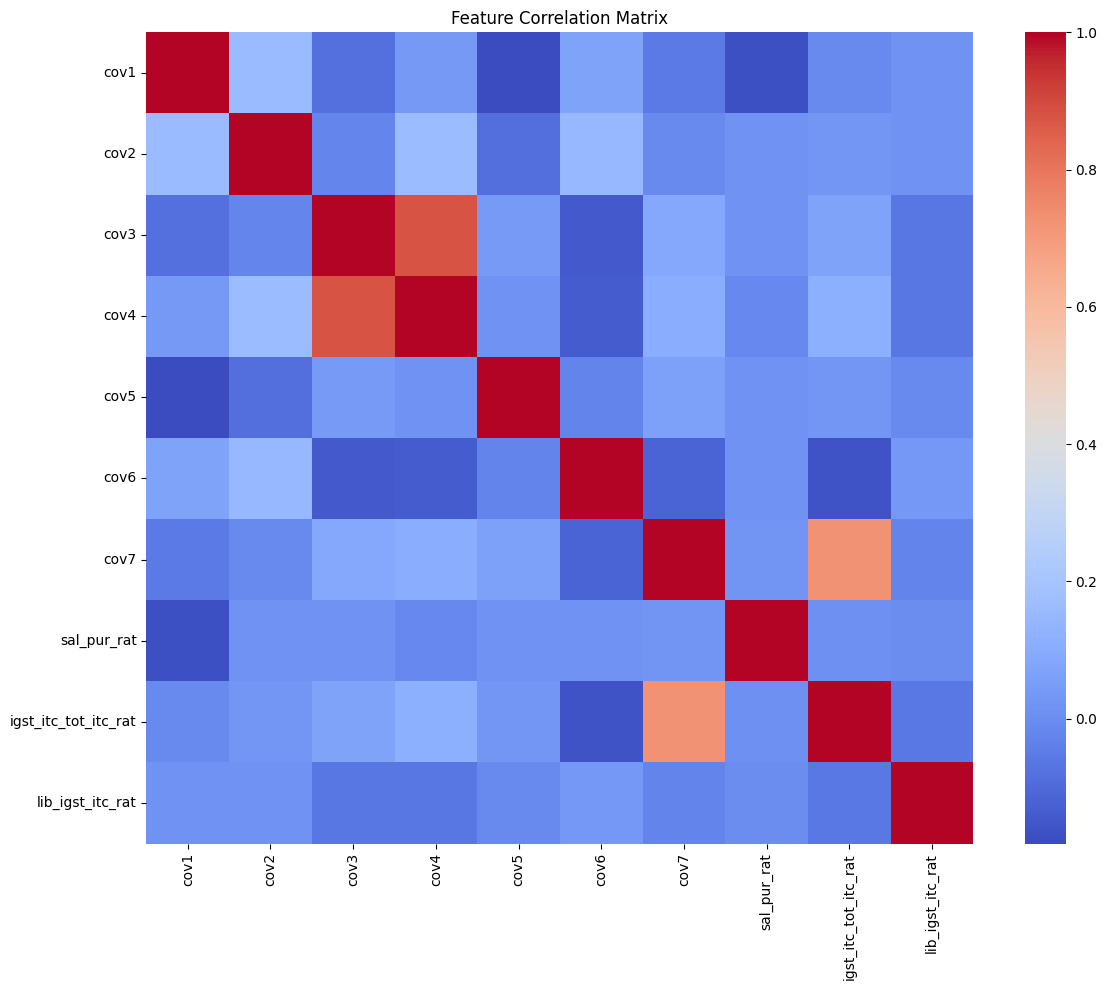

In [4]:
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show() 

#### Prepare data for training and Assuming all columns are features

In [5]:
X = data.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data for training and validation
X_train, X_val = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_full_tensor = torch.FloatTensor(X_scaled)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

#### Define the Variational Autoencoder

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2)
        )
        
        # Latent space
        self.mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim)
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def get_latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

# Loss function for VAE
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss

#### Train the VAE

In [7]:
def train_vae(model, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_idx, (data,) in enumerate(train_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (data,) in enumerate(val_loader):
                recon_batch, mu, logvar = model(data)
                loss = vae_loss(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show() 
    
    return model



#### Create and train the VAE model


Training VAE model...
Epoch 5/50, Train Loss: 9.4348, Val Loss: 7.3793
Epoch 10/50, Train Loss: 9.0376, Val Loss: 7.3575
Epoch 15/50, Train Loss: 8.7257, Val Loss: 6.9579
Epoch 20/50, Train Loss: 8.5219, Val Loss: 6.7811
Epoch 25/50, Train Loss: 8.1693, Val Loss: 6.7304
Epoch 30/50, Train Loss: 7.9449, Val Loss: 6.7629
Epoch 35/50, Train Loss: 7.5908, Val Loss: 6.5608
Epoch 40/50, Train Loss: 7.4660, Val Loss: 6.4577
Epoch 45/50, Train Loss: 7.0687, Val Loss: 6.4281
Epoch 50/50, Train Loss: 6.9681, Val Loss: 6.4241


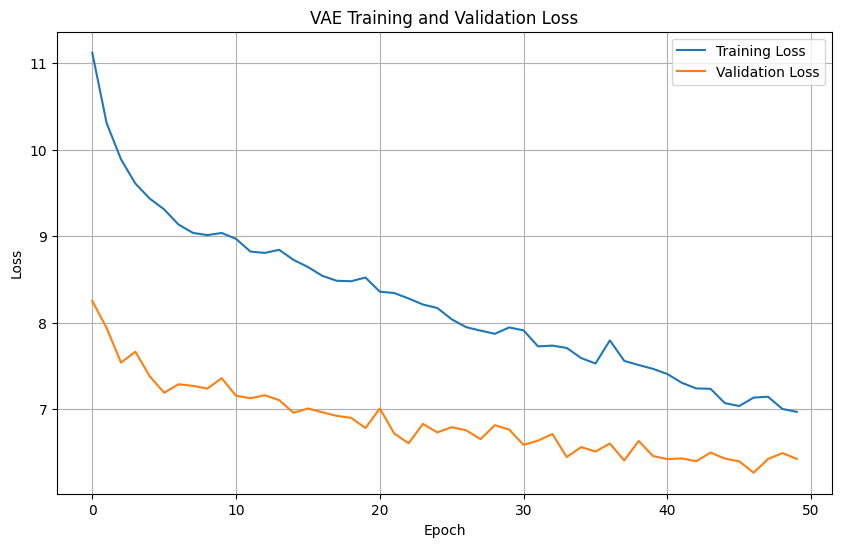

In [8]:
print("\nTraining VAE model...")
input_dim = X_scaled.shape[1]
hidden_dim = 64
latent_dim = 2  # Using 2D latent space for visualization

# Initialize the model and optimizer
vae_model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = Adam(vae_model.parameters(), lr=0.001)

# Train the model
vae_model = train_vae(vae_model, optimizer, num_epochs=50)


#### Compress data to latent space


Compressing data to latent space...


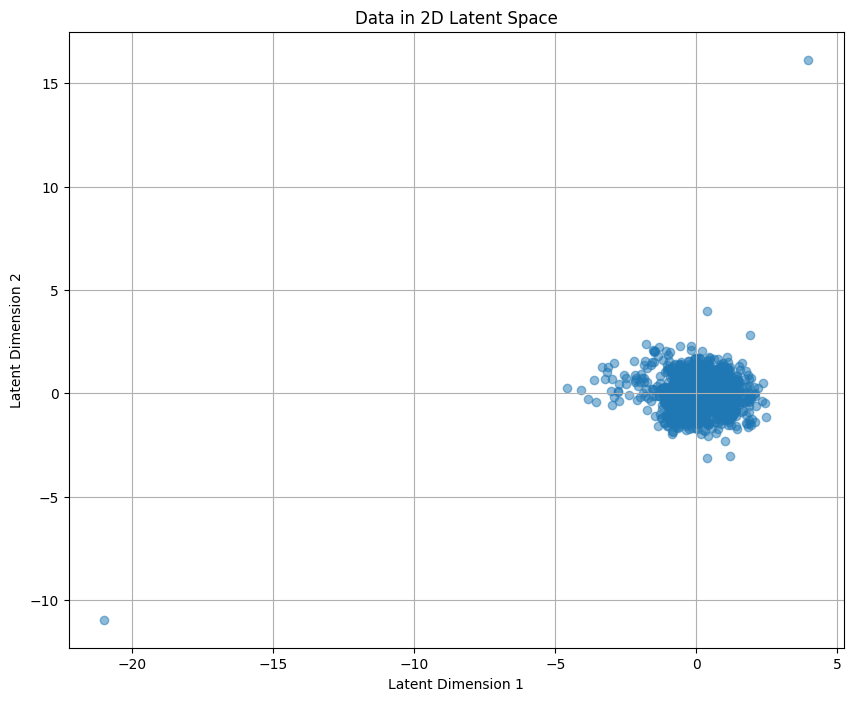

In [9]:
print("\nCompressing data to latent space...")
vae_model.eval()
with torch.no_grad():
    # Get latent representations
    latent_representations = vae_model.get_latent(X_full_tensor).numpy()

# Visualize latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], alpha=0.5)
plt.title('Data in 2D Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show() 

#### Find optimal number of clusters for K-Means


Finding optimal number of clusters...
K=2, Silhouette Score: 0.3196
K=3, Silhouette Score: 0.3147
K=4, Silhouette Score: 0.3372
K=5, Silhouette Score: 0.3412
K=6, Silhouette Score: 0.3694
K=7, Silhouette Score: 0.3386
K=8, Silhouette Score: 0.3384
K=9, Silhouette Score: 0.3330
K=10, Silhouette Score: 0.3243


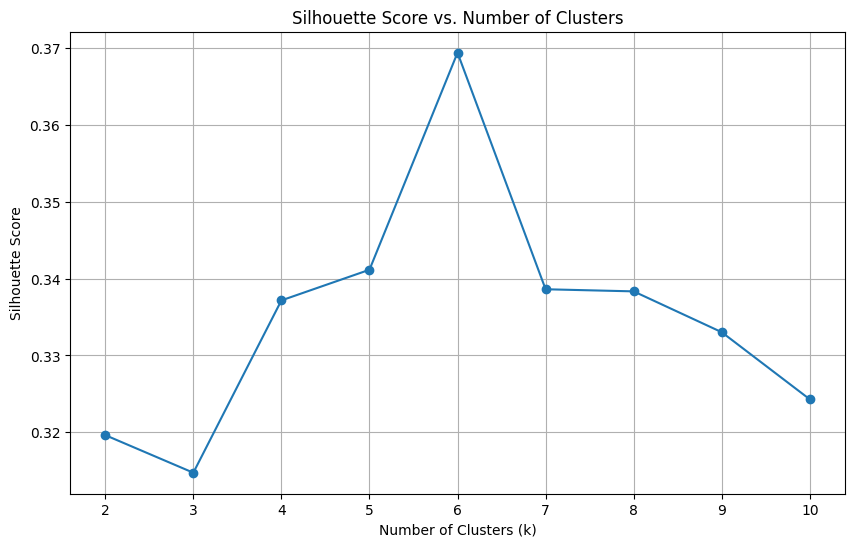


Optimal number of clusters: 6


In [10]:
print("\nFinding optimal number of clusters...")
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    cluster_labels = kmeans.fit_predict(latent_representations)
    silhouette_avg = silhouette_score(latent_representations, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K={k}, Silhouette Score: {silhouette_avg:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'o-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show() 

# Find optimal k (the one with highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

#### Perform K-Means clustering with optimal k


Performing K-Means clustering with k=6...


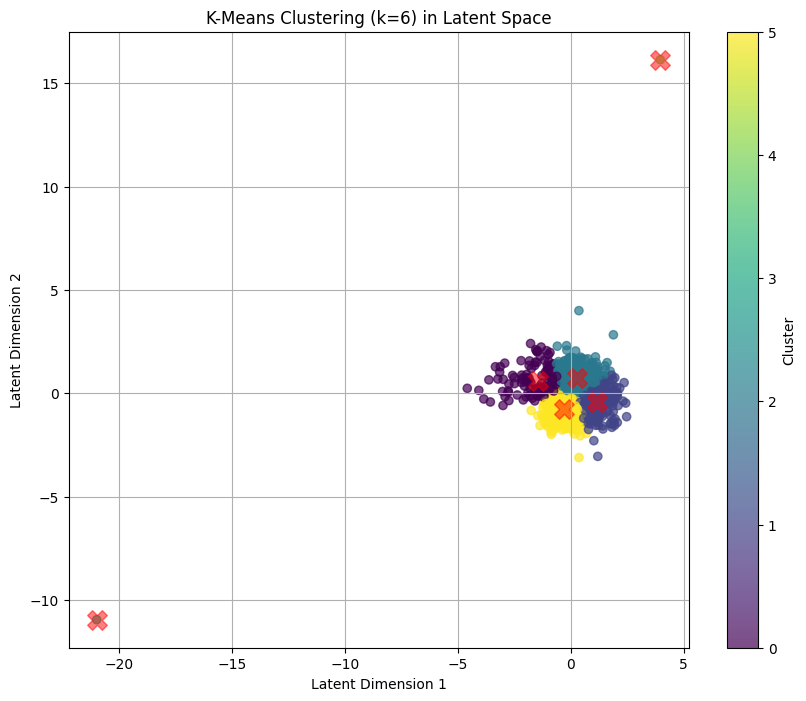

In [11]:
print(f"\nPerforming K-Means clustering with k={optimal_k}...")
kmeans = KMeans(n_clusters=optimal_k, n_init=10)
cluster_labels = kmeans.fit_predict(latent_representations)

# Visualize clusters in latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_representations[:, 0], latent_representations[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.7)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title(f'K-Means Clustering (k={optimal_k}) in Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

#### Identify outliers

In [12]:
# Method 1: Boundary points of big clusters
print("\nIdentifying boundary points of big clusters...")

# Count samples in each cluster
cluster_counts = np.bincount(cluster_labels)
big_cluster_threshold = np.mean(cluster_counts)
big_clusters = [i for i, count in enumerate(cluster_counts) if count > big_cluster_threshold]
print(f"Clusters with more than {big_cluster_threshold:.1f} points: {big_clusters}")

# For each big cluster, find points farthest from the center
boundary_outliers = []
for cluster in big_clusters:
    # Get points in this cluster
    cluster_points = latent_representations[cluster_labels == cluster]
    
    # Get cluster center
    center = kmeans.cluster_centers_[cluster]
    
    # Calculate distances from center
    distances = np.linalg.norm(cluster_points - center, axis=1)
    
    # Find threshold (e.g., 90th percentile)
    distance_threshold = np.percentile(distances, 95)
    
    # Find indices of points in the original dataset
    original_indices = np.where(cluster_labels == cluster)[0]
    boundary_indices = original_indices[distances > distance_threshold]
    
    boundary_outliers.extend(boundary_indices.tolist())

print(f"Found {len(boundary_outliers)} boundary outliers in big clusters")


Identifying boundary points of big clusters...
Clusters with more than 199.8 points: [1, 2, 5]
Found 55 boundary outliers in big clusters



Identifying points in small clusters...
Clusters with fewer than 99.9 points: [3, 4]
Found 2 outliers in small clusters

Total outliers found: 57


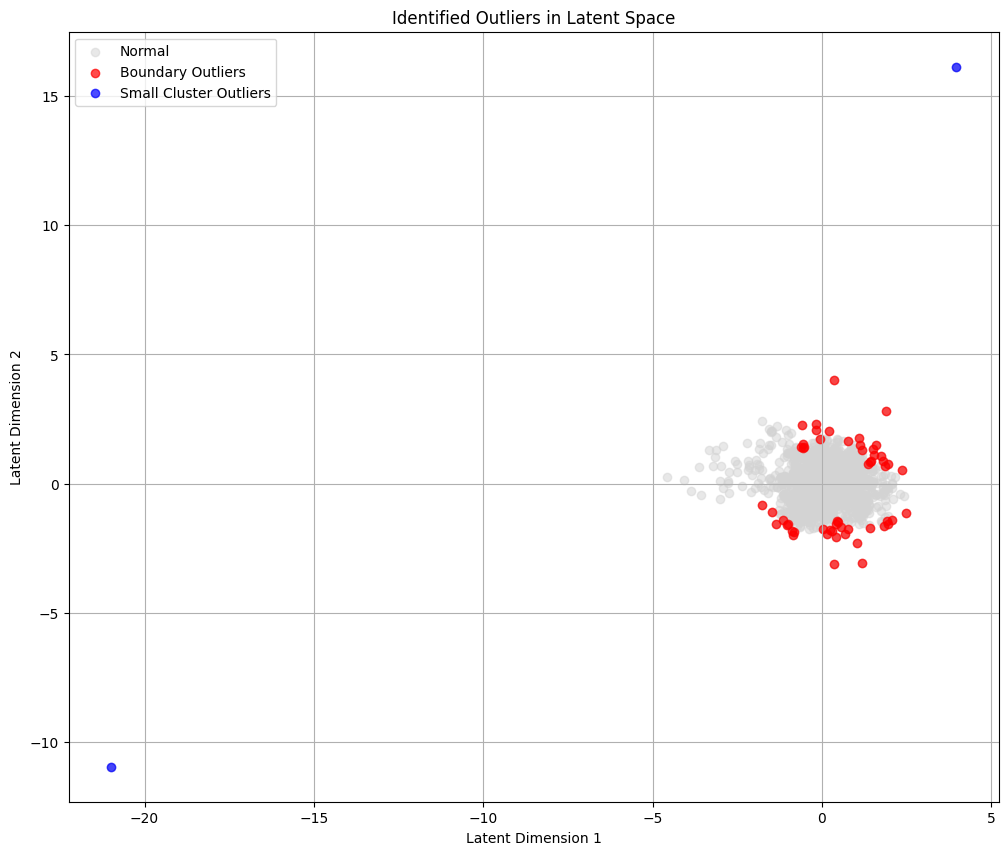

In [13]:
# Method 2: Points in small clusters
print("\nIdentifying points in small clusters...")
small_cluster_threshold = np.mean(cluster_counts) * 0.5  # Adjust as needed
small_clusters = [i for i, count in enumerate(cluster_counts) if count < small_cluster_threshold]
print(f"Clusters with fewer than {small_cluster_threshold:.1f} points: {small_clusters}")

small_cluster_outliers = []
for cluster in small_clusters:
    # Get indices of points in this small cluster
    outlier_indices = np.where(cluster_labels == cluster)[0]
    small_cluster_outliers.extend(outlier_indices.tolist())

print(f"Found {len(small_cluster_outliers)} outliers in small clusters")

# Combine all outliers
all_outliers = list(set(boundary_outliers + small_cluster_outliers))
print(f"\nTotal outliers found: {len(all_outliers)}")

# Visualize outliers in latent space
plt.figure(figsize=(12, 10))
# Plot all points in gray
plt.scatter(latent_representations[:, 0], latent_representations[:, 1], 
           color='lightgray', alpha=0.5, label='Normal')

# Plot boundary outliers in red
plt.scatter(latent_representations[boundary_outliers, 0], 
           latent_representations[boundary_outliers, 1], 
           color='red', alpha=0.7, label='Boundary Outliers')

# Plot small cluster outliers in blue
plt.scatter(latent_representations[small_cluster_outliers, 0], 
           latent_representations[small_cluster_outliers, 1], 
           color='blue', alpha=0.7, label='Small Cluster Outliers')

plt.title('Identified Outliers in Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
outlier_df = pd.DataFrame({
    'index': all_outliers,
    'original_data': [data.iloc[i].values.tolist() for i in all_outliers],
    'latent_representation': [latent_representations[i].tolist() for i in all_outliers],
    'cluster': [cluster_labels[i] for i in all_outliers]
})

outlier_df.to_csv('identified_outliers.csv', index=False)
print("\nOutliers saved to 'identified_outliers.csv'")

# Create a summary of the process
print("\n=== Summary ===")
print(f"Original data dimensions: {X.shape}")
print(f"Latent space dimensions: {latent_representations.shape}")
print(f"Optimal number of clusters: {optimal_k}")
print(f"Clusters with counts: {[f'Cluster {i}: {count}' for i, count in enumerate(cluster_counts)]}")
print(f"Boundary outliers: {len(boundary_outliers)}")
print(f"Small cluster outliers: {len(small_cluster_outliers)}")
print(f"Final outliers: {len(all_outliers)} ({len(all_outliers)/len(X)*100:.2f}% of data)")

print("\nAnalysis completed successfully!")



Outliers saved to 'identified_outliers.csv'

=== Summary ===
Original data dimensions: (1199, 10)
Latent space dimensions: (1199, 2)
Optimal number of clusters: 6
Clusters with counts: ['Cluster 0: 142', 'Cluster 1: 242', 'Cluster 2: 424', 'Cluster 3: 1', 'Cluster 4: 1', 'Cluster 5: 389']
Boundary outliers: 55
Small cluster outliers: 2
Final outliers: 57 (4.75% of data)

Analysis completed successfully!
